In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# Import data
df_data = pd.read_csv('data/data.csv')

# Define numpy arrays of data
J = df_data['J [mm/h]'].to_numpy()
Q = df_data['Q [mm/h]'].to_numpy()
ET = df_data['ET [mm/h]'].to_numpy()

In [3]:
# Define model parameters
S_u_ref = 100
S_l_ref = 2000
b_u = 10
b_l = 20
n = 0.5

P_bar = np.mean(J)

In [4]:
# Initialize hydrological components
S_u = np.zeros(len(J))
S_l = np.zeros_like(S_u)

L = np.zeros_like(S_u)
Q_l = np.zeros_like(S_u)
Q_s = np.zeros_like(S_u)

S_u[0] = S_u_ref
S_l[0] = S_l_ref

In [5]:
# Initialize WTT distributions
p_S_u = np.zeros([len(J), len(J)])
p_S_l = np.zeros_like(p_S_u)
p_Q_l = np.zeros_like(p_S_u) #np.zeros([len(J),2*len(J)]) for full convolution
p_Q_s = np.zeros_like(p_S_u)

norm_L = np.zeros_like(S_u)
norm_Q_l = np.zeros_like(S_u)

In [6]:
for j in range(len(J)-1):
    ## Hydrological model
    # upper box
    L[j] = P_bar * (S_u[j] / S_u_ref)**b_u
    S_u[j+1] = S_u[j] + J[j] - L[j]

    # lower box
    Q_l[j] = (1 - n) * P_bar * (S_l[j] / S_l_ref)**b_l
    S_l[j+1] = S_l[j] + (1-n) * L[j] - Q_l[j]

    # stream discharge
    Q_s[j] = n * L[j] + Q_l[j]


    ## Water Age balance
    # upper box
    norm_L[j] = L[j] / S_u[j]
    p_S_u[j,:j+1] = (J[j::-1] / S_u[j]) * np.exp(-np.cumsum(norm_L[j::-1]))

    # lower box
    norm_Q_l[j] = Q_l[j] / S_l[j]
    p_S_l[j,:j+1] = ((1 - n) * L[j::-1] / S_l[j]) * np.exp(-np.cumsum(norm_Q_l[j::-1]))
    p_Q_l[j,:j+1] = scipy.signal.convolve(p_S_l[j,:j+1], p_S_u[j,:j+1], mode='same', method='fft')
    #p_Q_l[j,:(2*(j+1)-1)] = scipy.signal.convolve(p_S_l[j,:j+1], p_S_u[j,:j+1], mode='full', method='fft')

    # streamflow age
    p_Q_s[j,:j+1] = n * L[j] / (n * L[j] + Q_l[j]) * p_S_u[j,:j+1] + Q_l[j] / (n * L[j] + Q_l[j]) * p_Q_l[j,:j+1]


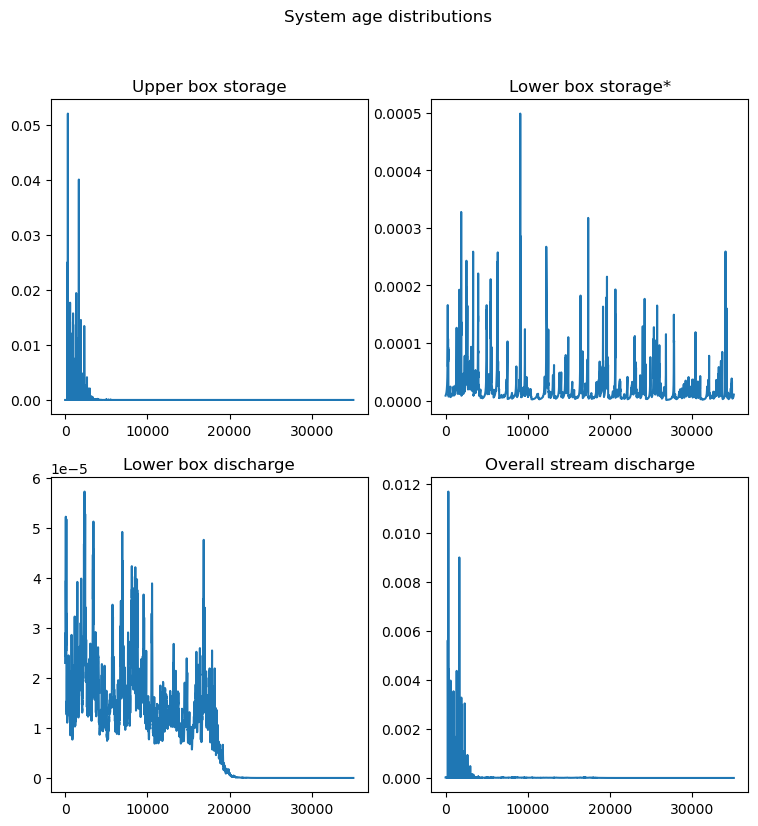

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

axs[1,0].plot(p_Q_l[j,:j+1])
axs[1,0].set_title('Lower box discharge')

axs[0,0].plot(p_S_u[j,:j+1])
axs[0,0].set_title('Upper box storage')

axs[0,1].plot(p_S_l[j,:j+1])
axs[0,1].set_title('Lower box storage*')

axs[1,1].plot(p_Q_s[j,:j+1])
axs[1,1].set_title('Overall stream discharge')

fig.suptitle('System age distributions');

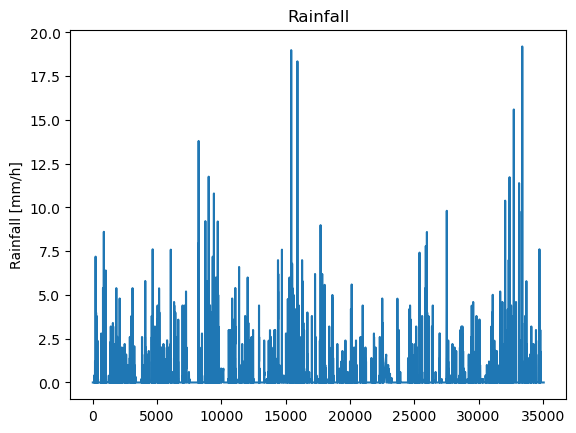

In [8]:
fig, ax = plt.subplots()

ax.plot(J)
ax.set_ylabel('Rainfall [mm/h]')
ax.set_title('Rainfall');
